In [1]:
!pip install summa

In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.17.1
2.2.2
1.2.0


In [3]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1. 데이터 수집하기

In [4]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.sample(10)

,headlines,text
13578,AAP minister denies seizure of Ã¢ÂÂ¹100cr ben...,Delhi minister Kailash Gahlot has denied claim...
32742,"Chinese firm breaks world record by flying 1,3...",Chinese drone company EHang Egret has broken t...
50272,Aadhaar added great strength to IndiaÃ¢ÂÂs d...,Prime Minister Narendra Modi on Sunday claimed...
40321,Kim Jong-un complaints to Russia over 'US hege...,North Korean leader Kim Jong-un complained of ...
78382,13-yr-old boy raped in Mumbai dies of multiple...,"A 13-year-old boy from Mumbai, who was alleged..."
25953,England end India's 3-ODI winning streak to le...,England registered an 86-run victory in the se...
5725,Pakistan Minister vows to protect 26/11 master...,A video has emerged online that shows Pakistan...
43931,"7,000 pairs of shoes displayed in US to protes...","Seven thousand pairs of shoes, representing th..."
95537,Elon Musk pranks about chemtrails being aliens...,SpaceX CEO Elon Musk pulled off an April Fools...
6153,MNF leader Zoramthanga sworn in as Chief Minis...,Mizo National Front chief Zoramthanga was swor...


# Step 2. 데이터 전처리하기 (추상적 요약)

## 중복값 및 결측치 제거

In [6]:
# 데이터 개수 확인
print("총 데이터 개수: ", len(data))

총 데이터 개수:  98401


In [7]:
# 중복 샘플과 NULL값이 존재하는 샘플 제거
print("text 열에서 중복을 배제한 유일한 샘플 수: ", data['text'].nunique())
print("headlines 열에서 중복을 배제한 유일한 샘플 수: ", data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플 수:  98360
headlines 열에서 중복을 배제한 유일한 샘플 수:  98280


In [8]:
# text, headline의 중복값 모두 삭제
data.drop_duplicates(subset = ['text'], inplace = True)
data.drop_duplicates(subset = ['headlines'], inplace = True)
print("중복 데이터 삭제 후 데이터 개수: ", len(data))

중복 데이터 삭제 후 데이터 개수:  98262


In [9]:
# null값 확인
data.isnull().sum()

,0
headlines,0
text,0


In [10]:
# headline, text 대략적인 길이 확인

data["headline_tokens"] = data["headlines"].apply(lambda x: len(x.split()))
data["text_tokens"] = data["text"].apply(lambda x: len(x.split()))

data.head()

,headlines,text,headline_tokens,text_tokens
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",13,60
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,12,60
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,9,60
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",9,60
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,13,60


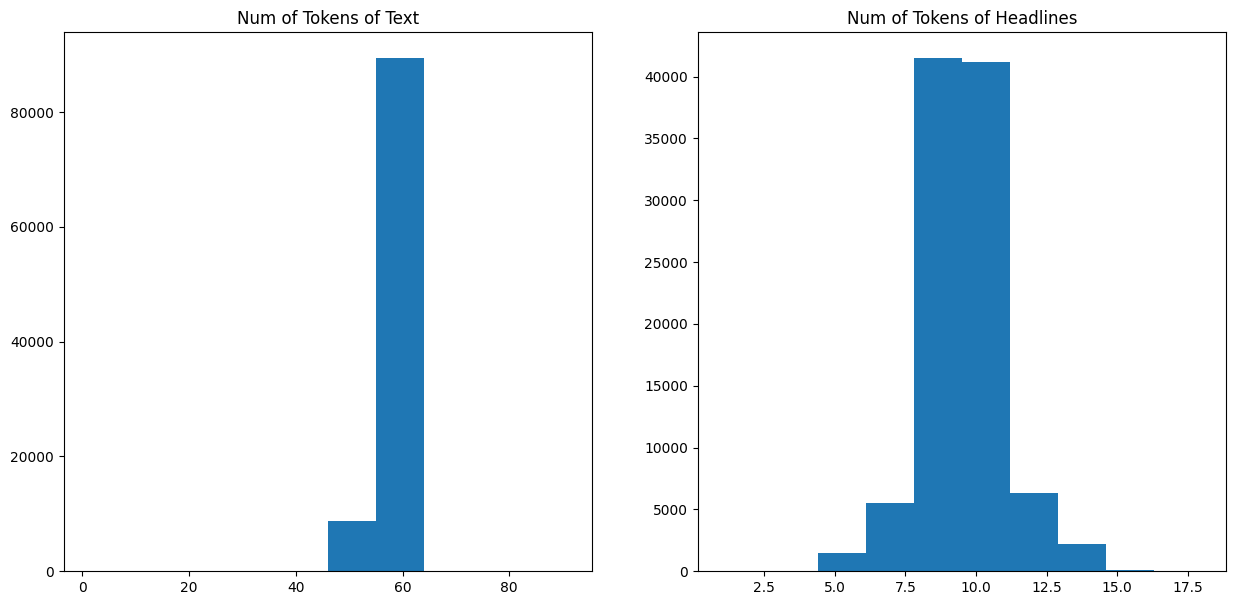

In [11]:
plt.figure(figsize = (15, 7))

plt.subplot(121)
plt.hist(data["text_tokens"])
plt.title("Num of Tokens of Text")

plt.subplot(122)
plt.hist(data["headline_tokens"])
plt.title("Num of Tokens of Headlines")

plt.show()

- headlines 토큰 개수 분포가 대부분 15 미만으로 불용어는 제거하지 않겠음

## 텍스트 정규화와 불용어 제거

In [12]:
# 정규화 사전 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [13]:
from nltk.corpus import stopwords

# nltk 불용어 사전 사용
nltk.download('stopwords')
print('불용어 개수: ', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수:  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").get_text(" ") # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"',  '', sentence) # 쌍따옴표 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b", "", sentence) # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자 제거
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경

    # 불용어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [15]:
from tqdm import tqdm
tqdm.pandas()

# text 데이터 전처리
data['text'] = data['text'].progress_apply(preprocess_sentence)
data.loc[:5, 'text']

100%|██████████| 98262/98262 [07:54<00:00, 207.21it/s]


,text
0,saurav kant alumnus upgrad iiit pg program mac...
1,kunal shah credit card bill payment platform c...
2,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan customers enjo...
4,speaking sexual harassment allegations rajkuma...
5,pakistani singer rahat fateh ali khan denied r...


In [16]:
# headlines 데이터 전처리
data['headlines'] = data['headlines'].progress_apply(lambda x: preprocess_sentence(x, False))
data.loc[:5, 'headlines']

  0%|          | 0/98262 [00:00<?, ?it/s]<ipython-input-14-fa130f3aadf9>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").get_text(" ") # html 태그 제거
100%|██████████| 98262/98262 [00:17<00:00, 5714.31it/s]


,headlines
0,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...
5,rahat fateh ali khan denies getting notice for...


In [103]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace = True)
data.isnull().sum()

,0
headlines,0
text,0
decoder_input,0
decoder_target,0


In [104]:
# Null 값이 있다면 dropna 로 삭제
data.dropna(axis = 0, inplace = True)
data.isnull().sum()

,0
headlines,0
text,0
decoder_input,0
decoder_target,0


## 샘플 최대 길이 정하기

In [105]:
# 데이터 전처리 후의 토큰 개수 값으로 업데이트
data['headline_tokens'] = data['headlines'].apply(lambda x : len(x.split()))
data['text_tokens'] = data['text'].apply(lambda x : len(x.split()))
data.head()

,headlines,text,decoder_input,decoder_target,headline_tokens,text_tokens
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...,11,39
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...,12,45
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...,10,38
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...,9,34
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...,10,34


In [106]:
# text, headline 데이터 집계값 찍기
data[['headline_tokens', 'text_tokens']].describe()

,headline_tokens,text_tokens
count,97072.000000,97072.000000
mean,9.252441,35.107559
std,1.330132,3.789476
min,1.000000,1.000000
25%,8.000000,33.000000
50%,9.000000,35.000000
75%,10.000000,38.000000
max,12.000000,50.000000


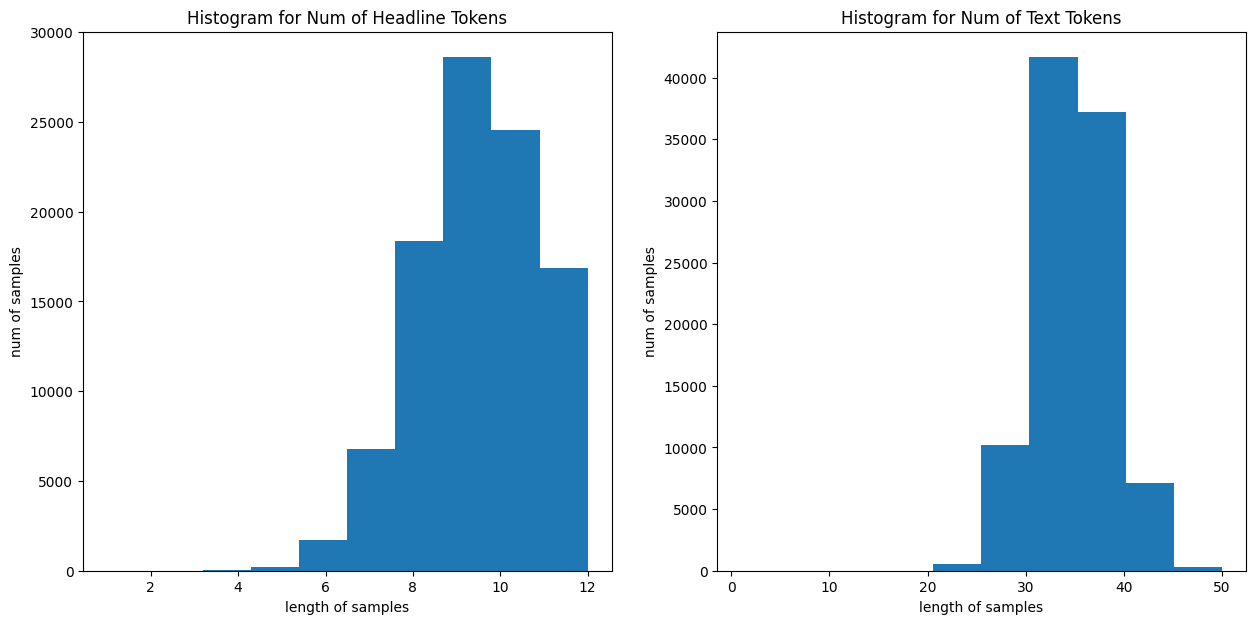

In [107]:
plt.figure(figsize = (15, 7))

plt.subplot(121)
plt.hist(data['headline_tokens'])
plt.xlabel('length of samples')
plt.ylabel('num of samples')
plt.title('Histogram for Num of Headline Tokens')

plt.subplot(122)
plt.hist(data['text_tokens'], bins = 10)
plt.xlabel('length of samples')
plt.ylabel('num of samples')
plt.title('Histogram for Num of Text Tokens')

plt.show()

In [108]:
# data coverage % 확인을 위한 함수 선언
def below_threshold_len(max_len, data, text= True):
    column_name = ''
    if text: column_name = 'text_tokens'
    else: column_name = 'headline_tokens'
    coverage = len(data[data[column_name] <= max_len])/len(data)
    return coverage

In [109]:
max_text_len = 50
max_headline_len = 12
print("text data coverage: ", below_threshold_len(max_text_len, data, True))
print("headline data coverage: ", below_threshold_len(max_headline_len, data, False))

text data coverage:  1.0
headline data coverage:  1.0


- text 길이 50인 경우 전체 데이터의 99.9% 커버 가능함
- headline 길이 12인 경우 전체 데이터의 98.8% 커버 가능함

In [110]:
# text 길이와 headline 길이 범위 밖의 데이터 삭제
data = data[data['headline_tokens'] <= max_headline_len]
data = data[data['text_tokens'] <= max_text_len]

print('전체 샘플 수:', len(data))

전체 샘플 수: 97072


In [111]:
# headline_tokens, text_tokens column 삭제
data.drop(['headline_tokens', 'text_tokens'], axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97072 entries, 0 to 98400
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   headlines       97072 non-null  object
 1   text            97072 non-null  object
 2   decoder_input   97072 non-null  object
 3   decoder_target  97072 non-null  object
dtypes: object(4)
memory usage: 3.7+ MB


## 시작 토큰과 종료 토큰 추가하기

In [112]:
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x )
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')

In [113]:
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [114]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [115]:
# 훈련 데이터와 테스트 데이터로 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices) # 인덱스 섞어주기
print(indices)

[76613 83778 80401 ... 57763 27820 73609]


In [116]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [117]:
# 8:2 비율로 훈련, 테스트 데이터 나누기
n_of_val = int(len(encoder_input)*0.2)
print("테스트 데이터 개수: ", n_of_val)

테스트 데이터 개수:  19414


In [118]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print("훈련 데이터 개수 :", len(encoder_input_train))
print("훈련 레이블 개수 :", len(decoder_input_train))
print("테스트 데이터 개수 :", len(encoder_input_test))
print("테스트 레이블 개수 :", len(decoder_input_test))

훈련 데이터 개수 : 77658
훈련 레이블 개수 : 77658
테스트 데이터 개수 : 19414
테스트 레이블 개수 : 19414


## 정수 인코딩

In [119]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [120]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69515
등장 빈도가 6번 이하인 희귀 단어의 수: 47477
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22038
단어 집합에서 희귀 단어의 비율: 68.29748975041358
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5390938954133517


 - 단어 집합에서 희귀 단어 비율이 68%임
 - 희귀 단어 등장 빈도는 전체 단어에서 3.5% 밖에 되지 않음
 - src_vocab의 개수를 약 20000개로 제한하겠음

In [121]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [122]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[50, 884, 160, 1, 137, 18, 1108, 15, 5652, 4, 1329, 422, 209, 1221, 9392, 36, 5, 214, 583, 344, 2180, 884, 1, 25, 779, 165, 2004], [7, 216, 39, 1638, 9994, 285, 23, 2676, 2340, 1611, 431, 1117, 249, 19356, 1, 1221, 1276, 1611, 466, 893, 77, 2886, 244, 772, 143, 3338, 285, 500, 5193, 10, 2073, 198, 1194, 143, 285, 1], [358, 352, 14, 6089, 6831, 41, 5, 16, 123, 42, 58, 1991, 346, 15871, 5, 377, 2367, 358, 16, 1729, 1189, 1365, 42, 192, 1, 346, 2668, 320, 15282, 5, 377, 125, 2444, 872, 2955, 1756, 1168]]


In [123]:
# headline 빈도수 계산 및 정수 시퀀스 변환
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30076
등장 빈도가 5번 이하인 희귀 단어의 수: 19700
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10376
단어 집합에서 희귀 단어의 비율: 65.50073148025002
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.714497450197201


In [124]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print("input ", decoder_input_train[:5])
print("decoder ", decoder_target_train[:5])

input  [[1, 44, 133, 134, 51, 1350, 7, 57, 6108, 4, 374, 405], [1, 311, 1018, 367, 35, 1522, 238, 4, 2331], [1, 30, 2663, 125, 164, 11, 7648, 4, 15, 611, 156], [1, 1128, 19, 18, 356, 98, 4, 5006, 1128, 4507], [1, 424, 149, 896, 8115, 82, 22, 1276, 4, 1042, 14, 1503]]
decoder  [[44, 133, 134, 51, 1350, 7, 57, 6108, 4, 374, 405, 2], [311, 1018, 367, 35, 1522, 238, 4, 2331, 2], [30, 2663, 125, 164, 11, 7648, 4, 15, 611, 156, 2], [1128, 19, 18, 356, 98, 4, 5006, 1128, 4507, 2], [424, 149, 896, 8115, 82, 22, 1276, 4, 1042, 14, 1503, 2]]


In [125]:
# 길이가 0이 된 샘플 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77658
훈련 레이블의 개수 : 77658
테스트 데이터의 개수 : 19414
테스트 레이블의 개수 : 19414


## 패딩하기

In [126]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headline_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headline_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headline_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headline_len, padding='post')

# Step 3. 어텐션 매커니즘 사용하기 (추상적 요약)

In [127]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [128]:
embedding_dim = 128
hidden_size = 256

#인코더
encoder_inputs = Input(shape = (max_text_len, ))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(encoder_output2)

In [129]:
# 디코더 설계
decoder_inputs = Input(shape = (None, ))

# 디코더 임베딩층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout =0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [130]:
# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = "softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 50, 128)        │      2,560,000 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ [(None, 50, 256),      │        394,240 │ embedding_10[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_21[0][0]          │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 50, 256),      │        525,312 │ lstm_20[0][0]          │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, None, 128)      │      1,280,000 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, None, 256),    │        394,240 │ embedding_11[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_20[1][1],         │
│                           │ 256)]                  │                │ lstm_20[1][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, None, 10000)    │      2,570,000 │ lstm_23[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,723,792 (29.46 MB)

 Trainable params: 7,723,792 (29.46 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name = 'attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis =-1, name = "concat_layer")([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation = "softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 50, 128)        │      2,560,000 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ [(None, 50, 256),      │        394,240 │ embedding_10[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_21[0][0]          │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 50, 256),      │        525,312 │ lstm_20[0][0]          │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, None, 128)      │      1,280,000 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, None, 256),    │        394,240 │ embedding_11[0][0],    │
│                           │ (None, 256), (None,    │                │ lstm_20[1][1],         │
│                           │ 256)]                  │                │ lstm_20[1][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_23[0][0],         │
│ (AdditiveAttention)       │                        │                │ lstm_20[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_23[0][0],         │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, None, 10000)    │      5,130,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,284,048 (39.23 MB)

 Trainable params: 10,284,048 (39.23 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
model.compile(optimizer= tensorflow.keras.optimizers.Adam(clipvalue = 1.0),
              loss='sparse_categorical_crossentropy')

In [1]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    "news_summary_best_model.keras",
    monitor = "val_loss",
    verbose = 0,
    save_best_only = True)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[checkpoint], epochs=50)

NameError: name 'tensorflow' is not defined

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현

In [ ]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(max_text_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (max_headline_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
import requests
from summa.summarizer import summarize

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, max_text_len)))
    print("Summa :", summarize(seq2text(encoder_input_test[i]), ratio = 0.1))
    print("\n")

# 회고

- 무엇이 문제인지는 모르겠으나, 모델 학습하는 과정에서 loss값이 infinite으로 넘어가면서 nan값으로 찍히고, 충돌로 커널이 끊겨버리는 현상이 발생함
- 아래와 같은 시도가 필요함...
    1. 데이터 샘플 개수 줄여서 다시 시도해볼 것
    2. tf.debugging.check_numerics(tensor, "Checking tensor for NaN/Inf")
    3. 입력값 정규화 수행
    4. softmax 대신 log-softmax 사용해보기